# STA 141B Final Project
Fall 2018

Xavier Hung

Weiyi Chen

## Problem: Do red light cameras result in more speeding?
### Case study: Chicago

The red light camera is intended to increase public safety by preventing running a red light, but it that really helpful?

We did a quick research on google and found some articles, most of them state red light camera result in more accidents, and the only purpose of the red light camera is generating millions of revenue for the government. However, according to the Insurance Institute for Highway Safety (IIHS),  fatal accidents caused by speeding can be reduced by up to 19% after the installation of red light cameras. 

To verify this statement, we focus on the association between red light cameras and speeding. We will compare the number of speeding that occurred at intersections before and after the use of red light camera to solve this problem. 

####  data extraction

We extracted data from the City of Chicago, an open data platform. There are four CSV files, red light camera locations, red light camera violations, speed camera locations, and speed camera violations (details of these data can be found at https://data.cityofchicago.org/browse?q=red+light+camera&sortBy=relevance).

In [13]:
import os
import pandas as pd
import numpy as np
import math
from ast import literal_eval
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import Title
from bokeh.tile_providers import CARTODBPOSITRON
import warnings
warnings.filterwarnings('ignore')

redlight_loc = pd.read_csv('red-light-camera-locations.csv')
redlight_violations = pd.read_csv('red-light-camera-violations.csv')

speed_loc = pd.read_csv('speed-camera-locations.csv')
speed_violations = pd.read_csv('speed-camera-violations.csv')

#### check shape and missing values

In [18]:
redlight_loc.shape, redlight_violations.shape, speed_loc.shape, speed_violations.shape

((149, 8), (423260, 10), (161, 7), (165141, 9))

In [22]:
redlight_loc.isnull().sum(), redlight_violations.isnull().sum(), speed_loc.isnull().sum(), speed_violations.isnull().sum()

(INTERSECTION         0
 FIRST APPROACH       0
 SECOND APPROACH      2
 THIRD APPROACH     145
 GO LIVE DATE         0
 LATITUDE             0
 LONGITUDE            0
 LOCATION             0
 dtype: int64, INTERSECTION          0
 CAMERA ID           552
 ADDRESS               0
 VIOLATION DATE        0
 VIOLATIONS            0
 X COORDINATE      24895
 Y COORDINATE      24895
 LATITUDE          24895
 LONGITUDE         24895
 LOCATION          24895
 dtype: int64, ADDRESS             0
 FIRST APPROACH      2
 SECOND APPROACH    94
 GO-LIVE DATE        0
 LATITUDE            0
 LONGITUDE           0
 LOCATION            0
 dtype: int64, ADDRESS              0
 CAMERA ID            0
 VIOLATION DATE       0
 VIOLATIONS           0
 X COORDINATE      6374
 Y COORDINATE      6374
 LATITUDE          6374
 LONGITUDE         6374
 LOCATION          6374
 dtype: int64)

`speed_loc` and `redlight_loc` have columns, latitude and longitude. We use Mercator projection to convert latitude and longitude into coordinates, and plot the locations of red light cameras and speed cameras.

In [67]:
# plot red light cameras and speed cameras locations
speed_loc["COORDINATES"] = '('+ speed_loc["LATITUDE"].astype(str) +','+ speed_loc["LONGITUDE"].astype(str) + ')'
redlight_loc["COORDINATES"] = '('+ redlight_loc["LATITUDE"].astype(str) +','+ redlight_loc["LONGITUDE"].astype(str) + ')'

def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

speed_loc['coords_x'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc['coords_y'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc['coords_x'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc['coords_y'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9790000, -9735000), y_range=(5105000, 5165000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc['coords_x'], y = redlight_loc['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc['coords_x'], y = speed_loc['coords_y'], legend = "Speed Camera", alpha=0.4)

t = Title()
t.text = 'Locations of All Speed Cameras and Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In Chicago, the 0.001 longitude is about 83 meters when latitudes are same. When longtitudes are same, the 0.001 latitude is about 111 meters. 
link: https://www.movable-type.co.uk/scripts/latlong.html

We are extracting the red light cameras and speed cameras that are near each other by 0.001 latitude and longitude. 

In [44]:
# redlight_loc_copy is a subset of redlight_loc and contains the locations of red light cameras near speed cameras
# speed_loc_copy is a subset of speed_loc and contains the locations of speed cameras near red light cameras
redlight_loc_copy = pd.DataFrame(columns = redlight_loc.columns.values)
speed_loc_copy = pd.DataFrame(columns = speed_loc.columns.values)
pairs = pd.DataFrame(columns = ['speed', 'redlight'])

# find red light cameras near speed cameras
for i in range(0,speed_loc.shape[0]):
    for j in range(0,redlight_loc.shape[0]):
        if abs(speed_loc.iloc[i,4] - redlight_loc.iloc[j,5]) < 0.001 and abs(speed_loc.iloc[i,5] - redlight_loc.iloc[j,6]) < 0.001:
            redlight_loc_copy = redlight_loc_copy.append(redlight_loc.iloc[j], ignore_index = True)
            speed_loc_copy = speed_loc_copy.append(speed_loc.iloc[i], ignore_index = True)
            temp = pd.DataFrame({'speed': [speed_loc.iloc[i,0]], 'redlight': [redlight_loc.iloc[j,0]]})
            pairs = pairs.append(temp)
pairs = pairs.reset_index(drop = True)

In [32]:
pairs.shape, redlight_loc_copy.shape,speed_loc_copy.shape

((18, 2), (18, 11), (18, 10))

In [47]:
# change format of addresses in speed_loc_copy to match format of addresses in speed_violations
remove = ["(Speed", "Camera)", "Ave", "ST", "Rd", "St", "Blvd",'Dr']
for i in range(0, speed_loc_copy.shape[0]):
    speed_loc_copy.iloc[i,0] = " ".join([word for word in speed_loc_copy.iloc[i,0].split() if word not in remove])

for i in range(0, pairs.shape[0]):
    pairs.iloc[i,0] = " ".join([word for word in pairs.iloc[i,0].split() if word not in remove]).upper()
    pairs.iloc[i,1] = pairs.iloc[i,1].upper()

In [49]:
pairs.head()

,speed,redlight
0,7826 S PULASKI,PULASKI-79TH
1,450 N COLUMBUS,ILLINOIS-COLUMBUS
2,3217 W 55TH,KEDZIE-55TH
3,3212 W 55TH,KEDZIE-55TH
4,7833 S PULASKI,PULASKI-79TH


In [56]:
speed_violations_copy = pd.DataFrame(columns = speed_violations.columns.values)    
# subset speed violations where speed cameras are near red light cameras
for i in range(0, speed_loc_copy.shape[0]):
    address = speed_violations[speed_violations['ADDRESS'].str.contains(speed_loc_copy.iloc[i,0].upper())]
    speed_violations_copy = speed_violations_copy.append(address, ignore_index = True)
    pairs.iloc[i,0] = address.iloc[0,0]            #violation address

In [58]:
pairs.head()

,speed,redlight
0,7826 S PULASKI,PULASKI-79TH
1,450 N COLUMBUS DR,ILLINOIS-COLUMBUS
2,3217 W 55TH ST,KEDZIE-55TH
3,3212 W 55TH ST,KEDZIE-55TH
4,7833 S PULASKI,PULASKI-79TH


In [59]:
redlight_violations_copy = pd.DataFrame(columns = redlight_violations.columns.values)

# subset red light violations where speed cameras are near red light cameras
# this will take a while
for i in range (0, redlight_violations.shape[0]):
    for j in range(0, redlight_loc_copy.shape[0]):
        intersection1 = redlight_violations.iloc[i,0].replace(' AND ', '/').replace(' and ', '/').split('/')
        intersection2 = redlight_loc_copy.iloc[j,0].split('-')
        if len(intersection1) > 1 and len(intersection2) > 1:
            if intersection1[0] == intersection2[0].upper() or intersection1[0] == intersection2[1].upper():
                if intersection1[1] == intersection2[0].upper() or intersection1[1] == intersection2[1].upper():
                    redlight_violations_copy = redlight_violations_copy.append(redlight_violations.iloc[i], ignore_index = True)
                    pairs.iloc[j,1] = redlight_violations.iloc[i,0]

In [61]:
redlight_loc_copy.isnull().sum(), speed_loc_copy.isnull().sum()

(INTERSECTION        0
 FIRST APPROACH      0
 SECOND APPROACH     0
 THIRD APPROACH     18
 GO LIVE DATE        0
 LATITUDE            0
 LONGITUDE           0
 LOCATION            0
 COORDINATES         0
 coords_x            0
 coords_y            0
 dtype: int64, ADDRESS             0
 FIRST APPROACH      0
 SECOND APPROACH    14
 GO-LIVE DATE        0
 LATITUDE            0
 LONGITUDE           0
 LOCATION            0
 COORDINATES         0
 coords_x            0
 coords_y            0
 dtype: int64)

In [69]:
# plot red light cameras near speed cameras
redlight_loc_copy["COORDINATES"] = '('+ redlight_loc_copy["LATITUDE"].astype(str) +','+ redlight_loc_copy["LONGITUDE"].astype(str) + ')'
speed_loc_copy["COORDINATES"] = '('+ speed_loc_copy["LATITUDE"].astype(str) +','+ speed_loc_copy["LONGITUDE"].astype(str) + ')'

speed_loc_copy['coords_x'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc_copy['coords_y'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc_copy['coords_x'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc_copy['coords_y'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9780000, -9745000), y_range=(5120000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc_copy['coords_x'], y = redlight_loc_copy['coords_y'], legend = "Red Light Camera", fill_color="#FF0000",size = 10)
p.circle(x = speed_loc_copy['coords_x'], y = speed_loc_copy['coords_y'], legend = "Speed Camera",alpha=0.5, size = 8)

t = Title()
t.text = 'Speed Cameras in Close Proximity to Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In [87]:
pairs

,speed,redlight
0,7826 S PULASKI,PULASKI AND 79TH
1,450 N COLUMBUS DR,COLUMBUS AND ILLINOIS
2,3217 W 55TH ST,55TH AND KEDZIE
3,3212 W 55TH ST,55TH AND KEDZIE
4,7833 S PULASKI,PULASKI AND 79TH
5,5532 S KEDZIE AVE,55TH AND KEDZIE
6,4123 N CENTRAL AVE,CENTRAL AND IRVING PARK
7,5428 S PULASKI,55TH and PULASKI
8,2335 W CERMAK RD,WESTERN AND CERMAK
9,732 N PULASKI RD,PULASKI AND CHICAGO


In [81]:
# find intersections that have the most and least red light violations and speed vioalations
redlight = redlight_violations_copy.groupby('INTERSECTION')['VIOLATIONS'].sum().sort_values(ascending = False)
most_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][0])].reset_index(drop = True)
second_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][1])].reset_index(drop = True)
third_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][2])].reset_index(drop = True)
least_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][len(redlight) - 1])].reset_index(drop = True)

speed = speed_violations_copy.groupby('ADDRESS')['VIOLATIONS'].sum().sort_values(ascending = False)
most_speed_violations = speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(speed.axes[0][0])].reset_index(drop = True)
least_speed_violations = speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(speed.axes[0][len(speed) - 1])].reset_index(drop = True)

In [95]:
redlight

INTERSECTION
COLUMBUS AND ILLINOIS      95013
PULASKI AND ARCHER         16910
PULASKI AND 79TH           16700
55TH AND KEDZIE            16665
COTTAGE GROVE AND 71ST     13722
55TH and PULASKI           13256
WESTERN AND ADDISON        12129
WESTERN AND CERMAK         10140
PULASKI AND CHICAGO         8046
CENTRAL AND IRVING PARK     7021
Name: VIOLATIONS, dtype: int64

In [89]:
# most_redlight_violations and most_redlight_speed are pairs
most_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == most_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    most_redlight_speed = most_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

# second_redlight_violations and second_redlight_speed are pairs
second_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == second_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    second_redlight_speed = second_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

# third_redlight_violations and third_redlight_speed are pairs
third_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == third_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    third_redlight_speed = third_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

# least_redlight_violations and least_redlight_speed are pairs
least_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == least_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    least_redlight_speed = least_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

# most_speed_violations and most_speed_redlight are pairs
most_speed_redlight = pd.DataFrame()
temp = pairs.loc[pairs['speed'] == most_speed_violations.iloc[0,0]].reset_index(drop = True)['redlight'].iloc[0]
most_speed_redlight = most_speed_redlight.append(redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(temp)].reset_index(drop = True))

# least_speed_violations and least_speed_redlight are pairs
least_speed_redlight = pd.DataFrame()
temp = pairs.loc[pairs['speed'] == least_speed_violations.iloc[0,0]].reset_index(drop = True)['redlight'].iloc[0]
least_speed_redlight = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(temp)].reset_index(drop = True)

### At most redlight violations intersections,COLUMBUS AND ILLINOIS <br>plot the nearby speed violations over time

In [101]:
# at most_redlight_violations intersections,  speed violations 
most_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == most_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
        most_redlight_speed = most_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

In [99]:
temp

['450 N COLUMBUS DR', '449 N COLUMBUS DR', '324 E ILLINOIS ST']

In [317]:
import plotnine as p9

most_redlight_speed['date'] = pd.to_datetime(most_redlight_speed['VIOLATION DATE'])
most_redlight_speed['yr_m'] = most_redlight_speed['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = most_redlight_speed.groupby(['ADDRESS','yr_m'])['VIOLATIONS'].sum()
plot1data = pd.DataFrame({'ADDRESS':temp.index.get_level_values('ADDRESS'), 'time':temp.index.get_level_values('yr_m'),'count':temp.values})

most_redlight_violations['date'] = pd.to_datetime(most_redlight_violations['VIOLATION DATE'])
most_redlight_violations['yr_m'] = most_redlight_violations['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = most_redlight_violations.groupby('yr_m')['VIOLATIONS'].sum()
temp = pd.DataFrame({'time':temp.index.get_level_values('yr_m'), 'count':temp.values,'ADDRESS':'COLUMBUS AND ILLINOIS'})

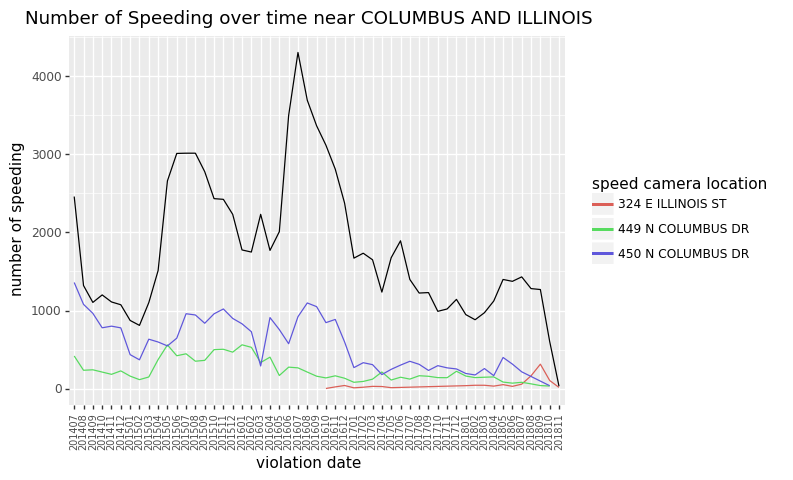

<ggplot: (-9223371902852500869)>

In [319]:
p9.ggplot(plot1data)+p9.aes(x='time', y='count',group='ADDRESS',color="ADDRESS")\
+p9.geom_line()+p9.theme(axis_text_x = p9.element_text(angle=90,size = 7))\
+p9.labs(title = 'Number of Speeding over time near COLUMBUS AND ILLINOIS',x = 'violation date',y='number of speeding',color='speed camera location')\
+p9.geom_line(data=temp,color='black')

### At second most redlight violations intersections,PULASKI AND ARCHER,<br>plot the nearby speed violations over time

In [312]:
# second_redlight_violations and second_redlight_speed are pairs
second_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == second_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    second_redlight_speed = second_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

In [314]:
temp

['5030 S PULASKI', '4929 S PULASKI']

In [320]:
second_redlight_speed['date'] = pd.to_datetime(second_redlight_speed['VIOLATION DATE'])
second_redlight_speed['yr_m'] = second_redlight_speed['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = second_redlight_speed.groupby(['ADDRESS','yr_m'])['VIOLATIONS'].sum()
plot2data = pd.DataFrame({'ADDRESS':temp.index.get_level_values('ADDRESS'), 'time':temp.index.get_level_values('yr_m'),'count':temp.values})

second_redlight_violations['date'] = pd.to_datetime(second_redlight_violations['VIOLATION DATE'])
second_redlight_violations['yr_m'] = second_redlight_violations['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = second_redlight_violations.groupby('yr_m')['VIOLATIONS'].sum()
temp = pd.DataFrame({'time':temp.index.get_level_values('yr_m'), 'count':temp.values,'ADDRESS':'PULASKI AND ARCHER'})

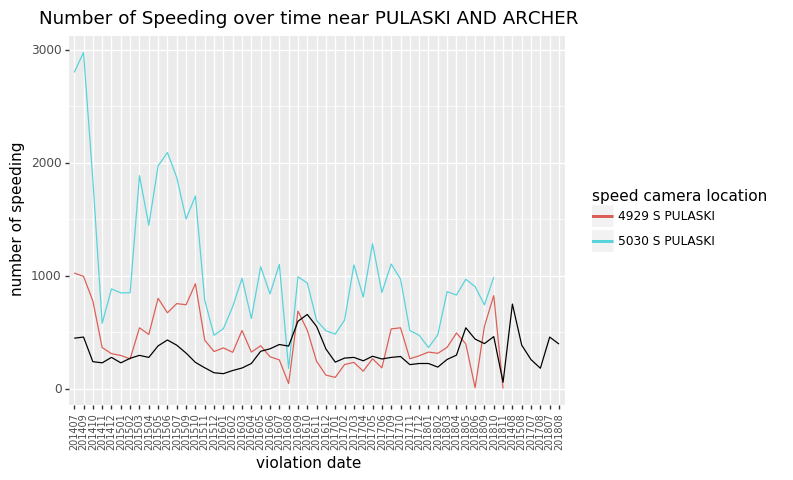

<ggplot: (-9223371902851819772)>

In [321]:
p9.ggplot(plot2data)+p9.aes(x='time', y='count',group='ADDRESS',color="ADDRESS")\
+p9.geom_line()+p9.theme(axis_text_x = p9.element_text(angle=90,size = 7))\
+p9.labs(title = 'Number of Speeding over time near PULASKI AND ARCHER',x = 'violation date',y='number of speeding',color='speed camera location')\
+p9.geom_line(data=temp,color='black')

### At least redlight violations intersections,CENTRAL AND IRVING PARK,<br>plot the nearby speed violations over time

In [322]:
# least_redlight_violations and least_redlight_speed are pairs
least_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == least_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    least_redlight_speed = least_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))
    
temp

['4123 N CENTRAL AVE']

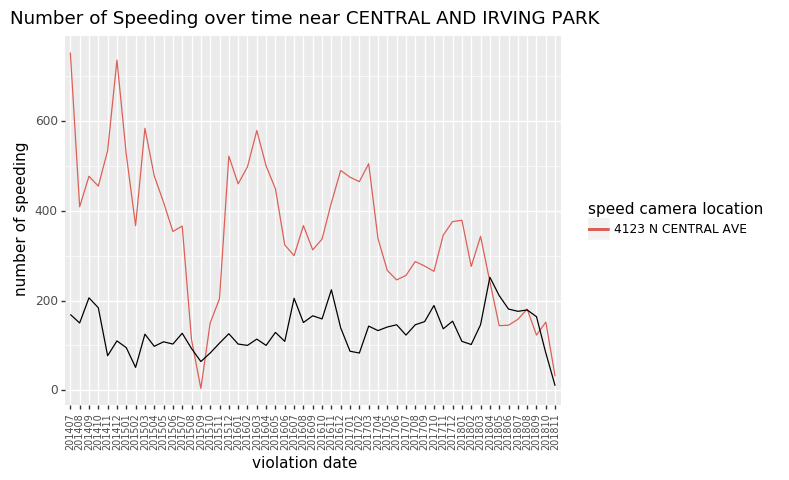

<ggplot: (-9223371902851904845)>

In [323]:
least_redlight_speed['date'] = pd.to_datetime(least_redlight_speed['VIOLATION DATE'])
least_redlight_speed['yr_m'] = least_redlight_speed['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = least_redlight_speed.groupby(['ADDRESS','yr_m'])['VIOLATIONS'].sum()
plot3data = pd.DataFrame({'ADDRESS':temp.index.get_level_values('ADDRESS'), 'time':temp.index.get_level_values('yr_m'),'count':temp.values})

least_redlight_violations['date'] = pd.to_datetime(least_redlight_violations['VIOLATION DATE'])
least_redlight_violations['yr_m'] = least_redlight_violations['date'].apply(lambda x: x.strftime('%Y%m'))   
temp = least_redlight_violations.groupby('yr_m')['VIOLATIONS'].sum()
temp = pd.DataFrame({'time':temp.index.get_level_values('yr_m'), 'count':temp.values,'ADDRESS':'CENTRAL AND IRVING PARK'})


p9.ggplot(plot3data)+p9.aes(x='time', y='count',group='ADDRESS',color="ADDRESS")\
+p9.geom_line()+p9.theme(axis_text_x = p9.element_text(angle=90,size = 7))\
+p9.labs(title = 'Number of Speeding over time near CENTRAL AND IRVING PARK',x = 'violation date',y='number of speeding',color='speed camera location')\
+p9.geom_line(data=temp,color='black')